In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

platforms=['android', 'ios']

In [2]:
query = """
select
        date_trunc('day', date) dt,
        os_name platform,
        iff(os_name='ios', 'id' || app_id, app_id) app_id,
        media_source,
        count(distinct iff(event_name = 'install', appsflyer_id, null))+sum(iff(event_name = 'af_skad_install', 1, 0)) total_installs,
        count(distinct iff(event_name = 'install', appsflyer_id, null)) regular_installs,
        sum(iff(event_name = 'af_skad_install', 1, 0)) skad_installs,
        count(distinct iff(event_name = 'retargeting', appsflyer_id, null)) retargeting,
        count(distinct iff(event_name = 'uninstall', appsflyer_id, null)) uninstalls,
        0 as cost
    from stage.reporting_marketing.appsflyer_installs_uninstalls
    where true 
    and date >= '2023-07-01'
    and app_id in (
        'com.hometogo',
        '1104996296'
    )
    group by 1,2,3,4
    order by 1,2,3,4
"""

In [3]:
data = df_from_snowflake(query)

In [4]:
data.DT=pd.to_datetime(data.DT)
data['is_paid']=data.MEDIA_SOURCE.isin(['Facebook Ads', 'googleadwords_int', 'Apple Search Ads'])

paid_installs=data.loc[data.is_paid].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()
organic_installs=data.loc[data.MEDIA_SOURCE=='organic'].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()



## Linear Function

In [5]:
def func(X, a ,b):
    return a + b*X

                r    Intercept Coefficient        R2
android  0.681989   742.154687    1.182443  0.465109
ios        0.7394  1358.462673    1.662904  0.546712

      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      


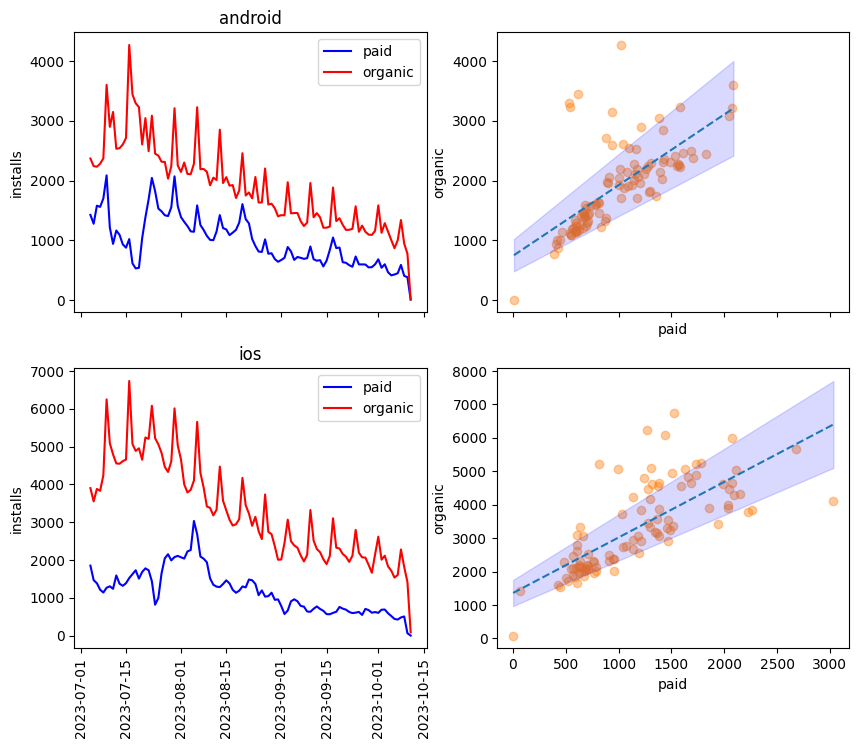

In [19]:
results = pd.DataFrame(index=platforms, columns=['r', 'Intercept', 'Coefficient', 'R2'])

_, ax = pp.subplots(nrows=len(platforms), ncols=2, sharex='col', figsize=(10, 8))
for n, platform in enumerate(platforms):
    X = paid_installs[platform].astype(float)
    y = organic_installs[platform].astype(float)
    
    ax[n,0].plot(X, color='blue', label='paid')
    ax[n,0].plot(y, color='red', label='organic')
    ax[n,0].set(title=platform)
    ax[n,0].legend()
    ax[n,0].tick_params(axis='x', labelrotation=90)
    ax[n,0].set_ylabel('installs')
    
    ## Fit regression line
    popt, pcov = curve_fit(
        func, 
        X, 
        y,
        p0=[0,0],
        #bounds=(0,1000)
    )
    x_ = np.linspace(X.min(), X.max())
    organic_predicted = func(x_, *popt)
    std = np.sqrt(np.diagonal(pcov))
    
    lower_bound = func(x_, *(popt - 1.96*std))
    upper_bound = func(x_, *(popt + 1.96*std))

    ## plot data points
    ax[n,1].scatter(x=X, y=y, color='C1', alpha=0.4)
    ## plot regression line
    ax[n,1].plot(x_, organic_predicted, linestyle='--')
    ax[n,1].fill_between(x_,
                         lower_bound,
                         upper_bound,
                         color='blue',
                         alpha=0.15
    )
    ax[n,1].set_xlabel('paid')
    ax[n,1].set_ylabel('organic')

    results.loc[platform, 'r'] = np.corrcoef([X, y]).min()
    results.loc[platform, ['Intercept', 'Coefficient']] = popt
    results.loc[platform, 'R2'] = r2_score(y, func(X, *popt))
    
print(results)
print("""
      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      """)

50

## Gaussian Function

In [13]:
def mean(x, y):
    return sum(x*y) / sum(y)

def sigma (x, y):
    return np.sqrt(sum(y * (x - mean(x, y))**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))


                r            a            b        sigma        R2
android  0.681989  2969.333675  2291.861843  1409.238963  0.461253
ios        0.7394   4790.61921  2128.523266  1216.966192  0.622454


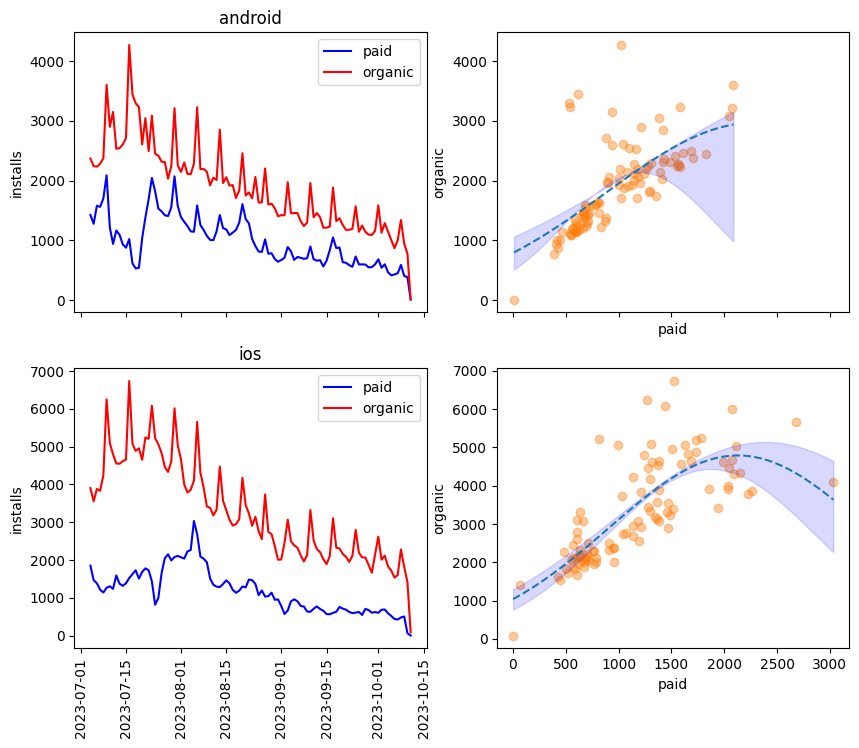

In [27]:
results_gauss = pd.DataFrame(index=platforms, columns=['r','a','b', 'sigma', 'R2'])

_, ax2 = pp.subplots(nrows=len(platforms), ncols=2, sharex='col', figsize=(10, 8))
for n, platform in enumerate(platforms):
    X=paid_installs[platform].astype(float)
    y=organic_installs[platform].astype(float)
    
    ax2[n,0].plot(X, color='blue', label='paid')
    ax2[n,0].plot(y, color='red', label='organic')
    ax2[n,0].set(title=platform)
    ax2[n,0].legend()
    ax2[n,0].tick_params(axis='x', labelrotation=90)
    ax2[n,0].set_ylabel('installs')
    

    popt,pcov = curve_fit(Gauss,
                          X, 
                          y, 
                          p0=[100, mean(X, y), sigma(X, y)]
    )
    
    x_ = np.linspace(X.min(), X.max())
    organic_predicted = Gauss(x_, *popt)
    std = np.sqrt(np.diagonal(pcov))                   # one standard deviation of parameters
    upper_bound = Gauss(x_, *(popt + 1.96*std))
    lower_bound = Gauss(x_, *(popt - 1.96*std))
    
    ## plot data points
    ax2[n,1].scatter(x=X, y=y, color='C1', alpha=0.4)
    ## plot regression line
    ax2[n,1].plot(x_, organic_predicted, linestyle='--')
    ax2[n,1].fill_between(x_,
                          lower_bound, 
                          upper_bound,
                          color = 'blue',
                          alpha = 0.15
    )
    ax2[n,1].set_xlabel('paid')
    ax2[n,1].set_ylabel('organic')

    results_gauss.loc[platform, 'r']=np.corrcoef([X, y]).min()
    results_gauss.loc[platform, ['a', 'b','sigma']]=popt
    results_gauss.loc[platform, 'R2'] = r2_score(y, Gauss(X, *popt))

print(results_gauss)